# Gradient Boosted Trees

In [1]:
from pi_pact_sort import bin_categorize, categorize

# Config
ADDITIONAL_FEATURES = ['HUMIDITY', 'PRESSURE']
CATEGORIZE_FUNC = bin_categorize

# Set objective for XGBClassifier and the file string for pickling
if len(ADDITIONAL_FEATURES) > 0:
    if len(ADDITIONAL_FEATURES) == 1:
        if 'HUMIDITY' in ADDITIONAL_FEATURES:
            feature_str = '3varH'
        else:
            feature_str = '3varP'
    else:
        feature_str = '4var'
else:
    feature_str = '2var'

if CATEGORIZE_FUNC == categorize:
    objective = 'multi:softmax'
    num_classes = 3
    metric='merror'
    scoring='accuracy'
    label_str = '3b'
else:
    objective = 'binary:logistic'
    num_classes = None
    metric='auc'
    scoring='roc_auc'
    label_str = 'binary'
    
file_str = f"xgboost-models/{feature_str}-{label_str}-xgboost-model.pickle"

In [2]:
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

import numpy as np
import pandas as pd
from pathlib import Path
import pickle
from sklearn.metrics import *
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

DROP_COLUMNS = ['ADDRESS', 'TIMESTAMP', 'UUID', 'MAJOR', 'MINOR', 'TX POWER', 'TEMPERATURE',
                'PITCH', 'ROLL', 'YAW', 'SCAN']
for feature in ['HUMIDITY', 'PRESSURE']:
    if feature not in ADDITIONAL_FEATURES:
        DROP_COLUMNS.append(feature)
SAMPLE_SIZE = 30000
np.random.seed(0)


"""Trains a Gradient Boosted Trees classifier to predict a distance range given RSSI values and other variables.
"""

# Initialize DataFrame
data: pd.DataFrame = pd.DataFrame(columns=['RSSI', 'DISTANCE'] + ADDITIONAL_FEATURES)
data_copy: pd.DataFrame = data.copy()
csv_file: Path
for csv_file in Path('.').glob('indoor-noObstruct-SenseHat*/*.csv'):
    datapart: pd.DataFrame = pd.read_csv(csv_file)
    for column in DROP_COLUMNS:
        if column in datapart.columns:
            datapart = datapart.drop([column], 1)
    data_copy = data_copy.append(datapart)

# Categorize distance
data_copy['DISTANCE'] = data_copy['DISTANCE'].map(CATEGORIZE_FUNC)

# Sample data from each distance category
for value in data_copy['DISTANCE'].unique():
    datapart = data_copy[data_copy.DISTANCE == value]
    datapart = datapart.sample(SAMPLE_SIZE, random_state=1)
    data = data.append(datapart)

# Assign features and labels
X: np.array = data.drop(['DISTANCE'], 1).to_numpy()
y: np.array = data['DISTANCE'].to_numpy(dtype=int)

Code below adapted from Aarshay Jain's "Complete Guide to Parameter Tuning in XGBoost with codes in Python", the article can be found at:`https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/` and the full code from the article can be found at: `https://github.com/aarshayj/analytics_vidhya/blob/master/Articles/Parameter_Tuning_XGBoost_with_Example/XGBoost%20models.ipynb`.

In [3]:
def modelfit(alg, X, y, useTrainCV=True, cv_folds=5, early_stopping_rounds=50) -> int:
    """
    Fits an 'XGBClassifier' instance and provides metrics for hyperparameter tuning.
    
    Args:
        alg (XGBClassifier): the 'XGBClassifier' instance to be fitted.
        X (np.array, shape=(n_samples, n_features)): the feature data.
        y (np.array, shape=(n_samples, )): the corresponding labels.
        useTrainCV (bool): controls whether cross-validation should be used.
        cv_folds (int): the number of folds to use for cross-validation.
        early_stopping_rounds (int): the maximum number of iterations that may occur without an increase in
            cross-validation score before training terminates. This value is passed to the native 'xgb.cv'.
            
    Returns:
        The optimal number of trees given `alg`'s parameters.
    """
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X, label=y, feature_names=['RSSI'] + ADDITIONAL_FEATURES)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'],
                          nfold=cv_folds, metrics=metric, early_stopping_rounds=early_stopping_rounds,
                          verbose_eval=True)
        best_n_estimators = cvresult.shape[0]
        alg.set_params(n_estimators=best_n_estimators)
    
    #Fit the algorithm on the data
    alg.fit(X, y, eval_metric=metric)
        
    #Predict training set:
    dtrain_predictions = alg.predict(X)
       
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % accuracy_score(y, dtrain_predictions))
    if CATEGORIZE_FUNC == bin_categorize:
        dtrain_predprob = alg.predict_proba(X)[:,1]
        print("AUC Score (Train): %f" % roc_auc_score(y, dtrain_predprob))
                    
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    
    if useTrainCV:
        return best_n_estimators

The first step of Jain's hyperparameter tuning process is to find the optimal number of trees with a fixed learning rate ($\eta=0.1$)

[0]	train-auc:0.76720+0.00146	test-auc:0.76522+0.00415
[1]	train-auc:0.98965+0.00025	test-auc:0.98927+0.00050
[2]	train-auc:0.98857+0.00501	test-auc:0.98791+0.00530
[3]	train-auc:0.98375+0.01190	test-auc:0.98257+0.01275
[4]	train-auc:0.98443+0.01647	test-auc:0.98318+0.01836
[5]	train-auc:0.98333+0.02082	test-auc:0.98200+0.02301
[6]	train-auc:0.99122+0.00523	test-auc:0.99044+0.00634
[7]	train-auc:0.99302+0.00245	test-auc:0.99258+0.00296
[8]	train-auc:0.99286+0.00299	test-auc:0.99229+0.00374
[9]	train-auc:0.99277+0.00373	test-auc:0.99215+0.00470
[10]	train-auc:0.99379+0.00207	test-auc:0.99326+0.00274
[11]	train-auc:0.99368+0.00239	test-auc:0.99310+0.00316
[12]	train-auc:0.99394+0.00171	test-auc:0.99348+0.00223
[13]	train-auc:0.99406+0.00134	test-auc:0.99364+0.00177
[14]	train-auc:0.99409+0.00142	test-auc:0.99366+0.00198
[15]	train-auc:0.99421+0.00116	test-auc:0.99380+0.00165
[16]	train-auc:0.99441+0.00085	test-auc:0.99399+0.00127
[17]	train-auc:0.99477+0.00067	test-auc:0.99438+0.00108
[1

[146]	train-auc:0.99855+0.00008	test-auc:0.99791+0.00026
[147]	train-auc:0.99856+0.00008	test-auc:0.99791+0.00026
[148]	train-auc:0.99856+0.00008	test-auc:0.99791+0.00026
[149]	train-auc:0.99857+0.00008	test-auc:0.99792+0.00027
[150]	train-auc:0.99857+0.00008	test-auc:0.99792+0.00027
[151]	train-auc:0.99858+0.00008	test-auc:0.99792+0.00026
[152]	train-auc:0.99859+0.00008	test-auc:0.99793+0.00026
[153]	train-auc:0.99860+0.00008	test-auc:0.99793+0.00026
[154]	train-auc:0.99860+0.00008	test-auc:0.99794+0.00026
[155]	train-auc:0.99861+0.00008	test-auc:0.99794+0.00026
[156]	train-auc:0.99861+0.00008	test-auc:0.99794+0.00026
[157]	train-auc:0.99862+0.00008	test-auc:0.99794+0.00026
[158]	train-auc:0.99862+0.00008	test-auc:0.99794+0.00026
[159]	train-auc:0.99863+0.00008	test-auc:0.99795+0.00026
[160]	train-auc:0.99864+0.00008	test-auc:0.99794+0.00027
[161]	train-auc:0.99864+0.00008	test-auc:0.99795+0.00027
[162]	train-auc:0.99864+0.00008	test-auc:0.99795+0.00027
[163]	train-auc:0.99865+0.00007

[290]	train-auc:0.99910+0.00004	test-auc:0.99803+0.00030
[291]	train-auc:0.99910+0.00004	test-auc:0.99803+0.00029
[292]	train-auc:0.99910+0.00004	test-auc:0.99803+0.00030
[293]	train-auc:0.99911+0.00004	test-auc:0.99803+0.00030
[294]	train-auc:0.99911+0.00004	test-auc:0.99803+0.00030
[295]	train-auc:0.99911+0.00004	test-auc:0.99803+0.00029
[296]	train-auc:0.99911+0.00004	test-auc:0.99803+0.00029
[297]	train-auc:0.99912+0.00004	test-auc:0.99803+0.00029
[298]	train-auc:0.99912+0.00004	test-auc:0.99803+0.00029
[299]	train-auc:0.99912+0.00004	test-auc:0.99803+0.00029
[300]	train-auc:0.99912+0.00004	test-auc:0.99803+0.00029
[301]	train-auc:0.99913+0.00004	test-auc:0.99803+0.00029
[302]	train-auc:0.99913+0.00004	test-auc:0.99803+0.00029
[303]	train-auc:0.99913+0.00004	test-auc:0.99803+0.00029
[304]	train-auc:0.99913+0.00004	test-auc:0.99803+0.00029
[305]	train-auc:0.99913+0.00004	test-auc:0.99803+0.00029
[306]	train-auc:0.99914+0.00004	test-auc:0.99803+0.00030
[307]	train-auc:0.99914+0.00004

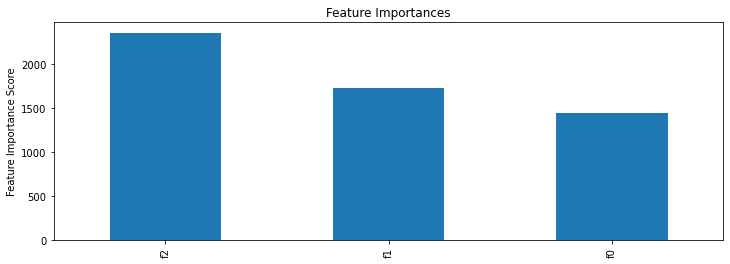

In [4]:
xgb1 = XGBClassifier(learning_rate =0.1,
                     n_estimators=1000,
                     max_depth=5,
                     min_child_weight=1,
                     gamma=0,
                     subsample=0.8,
                     colsample_bytree=0.8,
                     objective=objective,
                     num_class=num_classes,
                     nthread=4,
                     scale_pos_weight=1,
                     seed=0)
best_n_estimators_1 = modelfit(xgb1, X, y)

Then, we tune the integer parameters `max_depth` and `min_child_weight`.

In [5]:
param_test1 = {
     'max_depth': np.arange(1, 8, 1),
     'min_child_weight': np.arange(1, 8, 1)
}

gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, n_estimators=best_n_estimators_1,
                                                  max_depth=5, min_child_weight=1, gamma=0, subsample=0.8,
                                                  colsample_bytree=0.8, objective=objective,
                                                  num_class=num_classes, nthread=4, scale_pos_weight=1,
                                                  seed=0), 
                        param_grid = param_test1, scoring=scoring, n_jobs=4, cv=5)
gsearch1.fit(X, y)
best_max_depth = gsearch1.best_params_['max_depth']
best_min_child_weight = gsearch1.best_params_['min_child_weight']
print(gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_)

{'mean_fit_time': array([3.16374183, 3.21251664, 3.06181912, 2.93994112, 3.52737012,
       2.92577763, 3.15436726, 3.46693139, 4.89411607, 4.24226146,
       3.70410147, 3.76453691, 3.98853745, 3.96001339, 4.4726428 ,
       5.02556438, 4.83966222, 4.57856016, 4.6152617 , 4.39983821,
       4.35994411, 5.54637299, 7.7162787 , 5.7958528 , 5.66924424,
       5.71871166, 5.9056128 , 5.3778235 , 6.1844667 , 6.28021069,
       6.5441051 , 5.91239843, 6.34306383, 6.24071651, 6.17888222,
       8.61167908, 7.05675573, 7.12587929, 7.12355633, 6.99729381,
       7.18219924, 6.9883173 , 7.77840614, 8.02295189, 7.88352456,
       7.88691502, 7.8222981 , 7.73013821, 7.34476495]), 'std_fit_time': array([0.06320763, 0.07629593, 0.03114838, 0.05571953, 0.37107636,
       0.22889957, 0.04735156, 0.25271164, 0.29880028, 0.23464815,
       0.47730222, 0.24205486, 0.09285471, 0.22950904, 0.14277393,
       0.39112742, 0.30234555, 0.46390252, 0.31435197, 0.19553096,
       0.33377652, 0.26277263, 1.09506

Next, we tune the `gamma` parameter.

In [6]:
param_test2 = {
     'gamma':[i/10.0 for i in range(0,5)]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=best_n_estimators_1,
                                                  max_depth=best_max_depth,
                                                  min_child_weight=best_min_child_weight,
                                                  gamma=0, subsample=0.8, colsample_bytree=0.8,
                                                  objective=objective, num_class=num_classes,
                                                  nthread=4, scale_pos_weight=1, seed=0), 
                        param_grid = param_test2, scoring=scoring, n_jobs=4, cv=5)
gsearch2.fit(X, y)
best_gamma = gsearch2.best_params_['gamma']
print(gsearch2.cv_results_, gsearch2.best_params_, gsearch2.best_score_)

{'mean_fit_time': array([6.31801548, 7.16636152, 6.38134136, 5.61878099, 5.15382257]), 'std_fit_time': array([0.69898263, 0.88726499, 0.32841042, 0.51562989, 0.49071195]), 'mean_score_time': array([0.0682178 , 0.07938676, 0.07579637, 0.06282988, 0.06163526]), 'std_score_time': array([0.00241049, 0.00753174, 0.01117801, 0.00141247, 0.00193357]), 'param_gamma': masked_array(data=[0.0, 0.1, 0.2, 0.3, 0.4],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'gamma': 0.0}, {'gamma': 0.1}, {'gamma': 0.2}, {'gamma': 0.3}, {'gamma': 0.4}], 'split0_test_score': array([0.99794508, 0.99795318, 0.9979635 , 0.99797101, 0.99795815]), 'split1_test_score': array([0.99813878, 0.99810303, 0.99812194, 0.99812131, 0.99810597]), 'split2_test_score': array([0.99784601, 0.99785586, 0.99780661, 0.99782824, 0.99781135]), 'split3_test_score': array([0.99818743, 0.99819465, 0.99820267, 0.99818903, 0.99819982]), 'split4_test_score': array([0.998094

Before we proceed, Jain recommends recalibrating the value of `n_estimators` with our new parameters.

[0]	train-auc:0.76719+0.00142	test-auc:0.76541+0.00416
[1]	train-auc:0.98962+0.00025	test-auc:0.98927+0.00053
[2]	train-auc:0.98855+0.00503	test-auc:0.98791+0.00530
[3]	train-auc:0.98370+0.01195	test-auc:0.98257+0.01275
[4]	train-auc:0.98450+0.01630	test-auc:0.98333+0.01808
[5]	train-auc:0.98320+0.02103	test-auc:0.98194+0.02318
[6]	train-auc:0.99112+0.00540	test-auc:0.99037+0.00653
[7]	train-auc:0.99299+0.00247	test-auc:0.99257+0.00298
[8]	train-auc:0.99283+0.00300	test-auc:0.99228+0.00375
[9]	train-auc:0.99276+0.00372	test-auc:0.99215+0.00471
[10]	train-auc:0.99378+0.00207	test-auc:0.99327+0.00275
[11]	train-auc:0.99362+0.00243	test-auc:0.99307+0.00318
[12]	train-auc:0.99391+0.00172	test-auc:0.99347+0.00226
[13]	train-auc:0.99404+0.00136	test-auc:0.99363+0.00180
[14]	train-auc:0.99408+0.00144	test-auc:0.99366+0.00201
[15]	train-auc:0.99420+0.00116	test-auc:0.99380+0.00167
[16]	train-auc:0.99440+0.00085	test-auc:0.99400+0.00128
[17]	train-auc:0.99476+0.00067	test-auc:0.99438+0.00109
[1

[146]	train-auc:0.99850+0.00009	test-auc:0.99790+0.00028
[147]	train-auc:0.99851+0.00009	test-auc:0.99791+0.00028
[148]	train-auc:0.99851+0.00008	test-auc:0.99791+0.00029
[149]	train-auc:0.99852+0.00008	test-auc:0.99792+0.00029
[150]	train-auc:0.99853+0.00008	test-auc:0.99792+0.00029
[151]	train-auc:0.99853+0.00008	test-auc:0.99792+0.00029
[152]	train-auc:0.99854+0.00008	test-auc:0.99793+0.00029
[153]	train-auc:0.99854+0.00008	test-auc:0.99793+0.00029
[154]	train-auc:0.99855+0.00008	test-auc:0.99793+0.00029
[155]	train-auc:0.99856+0.00008	test-auc:0.99794+0.00029
[156]	train-auc:0.99856+0.00007	test-auc:0.99794+0.00029
[157]	train-auc:0.99857+0.00007	test-auc:0.99794+0.00029
[158]	train-auc:0.99858+0.00007	test-auc:0.99794+0.00030
[159]	train-auc:0.99859+0.00007	test-auc:0.99795+0.00030
[160]	train-auc:0.99859+0.00007	test-auc:0.99795+0.00030
[161]	train-auc:0.99859+0.00006	test-auc:0.99795+0.00030
[162]	train-auc:0.99860+0.00006	test-auc:0.99795+0.00031
[163]	train-auc:0.99860+0.00006

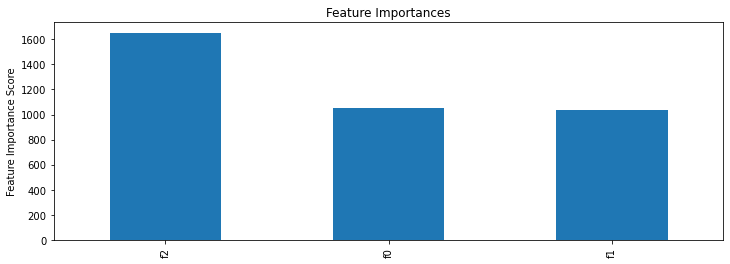

In [7]:
xgb2 = XGBClassifier(learning_rate=0.1,
                     n_estimators=1000,
                     max_depth=best_max_depth,
                     min_child_weight=best_min_child_weight,
                     gamma=best_gamma,
                     subsample=0.8,
                     colsample_bytree=0.8,
                     objective=objective,
                     num_class=num_classes,
                     nthread=4,
                     scale_pos_weight=1,
                     seed=0)
best_n_estimators_2 = modelfit(xgb2, X, y)

Jain's next step is to tune `subsample` and `colsample_bytree`.

In [10]:
param_test3 = {
     'subsample':[i/100.0 for i in range (75, 85, 1)],
     'colsample_bytree':[i/100.0 for i in range(65, 75, 1)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, n_estimators=best_n_estimators_2,
                                                  max_depth=best_max_depth,
                                                  min_child_weight=best_min_child_weight,
                                                  gamma=best_gamma, subsample=0.8,
                                                  colsample_bytree=0.8,
                                                  objective=objective, num_class=num_classes, 
                                                  nthread=4, scale_pos_weight=1, seed=0), 
                        param_grid = param_test3, scoring=scoring, n_jobs=4, cv=5)
gsearch3.fit(X, y)
best_subsample = gsearch3.best_params_['subsample']
best_colsample_bytree = gsearch3.best_params_['colsample_bytree']
print(gsearch3.cv_results_, gsearch3.best_params_, gsearch3.best_score_)

{'mean_fit_time': array([5.24238577, 4.13813701, 3.44649215, 3.58531718, 4.44352779,
       3.50323505, 5.40096126, 5.0618681 , 5.93792562, 4.54963751,
       3.97656884, 4.1949852 , 4.28614192, 5.19172206, 5.30282216,
       4.09525185, 6.35591984, 3.99801745, 3.97517333, 4.10023866,
       4.47485189, 5.28547044, 5.08890238, 4.56948662, 4.73635316,
       4.43773556, 4.53168569, 6.38014364, 4.84526396, 4.93700056,
       5.21468492, 5.69717684, 4.8610043 , 4.63082352, 4.2237114 ,
       4.03720794, 4.03800511, 4.03601007, 4.02244663, 3.67896481,
       4.24804335, 4.02404184, 3.746983  , 3.91493406, 4.16825657,
       4.08906875, 4.08248644, 4.0441885 , 4.01985345, 4.08029208,
       3.82557278, 4.7858057 , 4.89571252, 4.34358873, 3.94884405,
       4.18979912, 3.97656984, 3.99152899, 3.92730098, 3.91473451,
       4.09824405, 4.08029199, 4.0459836 , 4.18321676, 4.54445181,
       4.11220689, 4.32344484, 4.15369573, 3.73082638, 4.59112663,
       4.66564288, 3.96370821, 3.88720818, 4

Then we tune `reg_alpha` and `reg_lambda`.

In [13]:
param_test4 = {
     'reg_alpha': [0, 1e-8, 1e-6],
     'reg_lamba': [0, ]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, n_estimators=best_n_estimators_2,
                                                  max_depth=best_max_depth,
                                                  min_child_weight=best_min_child_weight,
                                                  gamma=best_gamma, subsample=best_subsample,
                                                  colsample_bytree=best_colsample_bytree,
                                                  objective=objective, num_class=num_classes,
                                                  nthread=4, scale_pos_weight=1, seed=0), 
                        param_grid=param_test4, scoring=scoring, n_jobs=4, cv=5)
gsearch4.fit(X, y)
best_alpha = gsearch4.best_params_['reg_alpha']
best_lambda = gsearch4.best_params_['reg_lamba']
print(gsearch4.cv_results_, gsearch4.best_params_, gsearch4.best_score_)

[22:52:08] WARNING: C:\Users\Winst\AppData\Local\Temp\pip-req-build-ckz7_hhx\build\temp.win-amd64-3.7\Release\xgboost\src\learner.cc:489: 
Parameters: { reg_lamba } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


{'mean_fit_time': array([4.44252472, 4.47643304, 4.75748167]), 'std_fit_time': array([0.08049315, 0.23590626, 0.15990878]), 'mean_score_time': array([0.0508636 , 0.05704737, 0.06183496]), 'std_score_time': array([0.00302549, 0.00940642, 0.0132759 ]), 'param_reg_alpha': masked_array(data=[0, 1e-08, 1e-06],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'param_reg_lamba': masked_array(data=[0, 0, 0],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'reg_alpha': 0, 'reg_lamba'

We finish by reducing $\eta$ and increasing `n_estimators`.

[22:52:37] WARNING: C:\Users\Winst\AppData\Local\Temp\pip-req-build-ckz7_hhx\build\temp.win-amd64-3.7\Release\xgboost\src\learner.cc:489: 
Parameters: { reg_lamba } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:52:37] WARNING: C:\Users\Winst\AppData\Local\Temp\pip-req-build-ckz7_hhx\build\temp.win-amd64-3.7\Release\xgboost\src\learner.cc:489: 
Parameters: { reg_lamba } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:52:37] WARNING: C:\Users\Winst\AppData\Local\Temp\pip-req-build-ckz7_hhx\build\temp.win-amd64-3.7\Release\xgboost\src\learner.cc:489: 
Parameters: {

[109]	train-auc:0.99435+0.00035	test-auc:0.99405+0.00044
[110]	train-auc:0.99439+0.00035	test-auc:0.99408+0.00045
[111]	train-auc:0.99439+0.00033	test-auc:0.99408+0.00046
[112]	train-auc:0.99440+0.00032	test-auc:0.99410+0.00045
[113]	train-auc:0.99443+0.00030	test-auc:0.99412+0.00045
[114]	train-auc:0.99442+0.00031	test-auc:0.99410+0.00043
[115]	train-auc:0.99444+0.00034	test-auc:0.99413+0.00041
[116]	train-auc:0.99444+0.00037	test-auc:0.99414+0.00040
[117]	train-auc:0.99449+0.00036	test-auc:0.99418+0.00039
[118]	train-auc:0.99450+0.00036	test-auc:0.99420+0.00038
[119]	train-auc:0.99451+0.00038	test-auc:0.99421+0.00036
[120]	train-auc:0.99452+0.00034	test-auc:0.99422+0.00039
[121]	train-auc:0.99452+0.00033	test-auc:0.99421+0.00039
[122]	train-auc:0.99453+0.00035	test-auc:0.99422+0.00038
[123]	train-auc:0.99454+0.00033	test-auc:0.99424+0.00039
[124]	train-auc:0.99456+0.00032	test-auc:0.99426+0.00039
[125]	train-auc:0.99457+0.00032	test-auc:0.99426+0.00038
[126]	train-auc:0.99459+0.00031

[253]	train-auc:0.99594+0.00017	test-auc:0.99559+0.00046
[254]	train-auc:0.99595+0.00017	test-auc:0.99560+0.00046
[255]	train-auc:0.99596+0.00016	test-auc:0.99562+0.00046
[256]	train-auc:0.99596+0.00016	test-auc:0.99562+0.00046
[257]	train-auc:0.99597+0.00016	test-auc:0.99562+0.00047
[258]	train-auc:0.99598+0.00016	test-auc:0.99563+0.00047
[259]	train-auc:0.99598+0.00016	test-auc:0.99563+0.00046
[260]	train-auc:0.99599+0.00015	test-auc:0.99564+0.00046
[261]	train-auc:0.99600+0.00015	test-auc:0.99565+0.00047
[262]	train-auc:0.99601+0.00016	test-auc:0.99565+0.00047
[263]	train-auc:0.99602+0.00017	test-auc:0.99566+0.00046
[264]	train-auc:0.99602+0.00017	test-auc:0.99567+0.00046
[265]	train-auc:0.99603+0.00017	test-auc:0.99568+0.00046
[266]	train-auc:0.99604+0.00017	test-auc:0.99569+0.00046
[267]	train-auc:0.99605+0.00017	test-auc:0.99570+0.00046
[268]	train-auc:0.99606+0.00017	test-auc:0.99571+0.00046
[269]	train-auc:0.99607+0.00017	test-auc:0.99571+0.00046
[270]	train-auc:0.99608+0.00017

[397]	train-auc:0.99689+0.00009	test-auc:0.99650+0.00046
[398]	train-auc:0.99690+0.00009	test-auc:0.99651+0.00046
[399]	train-auc:0.99690+0.00009	test-auc:0.99651+0.00046
[400]	train-auc:0.99690+0.00009	test-auc:0.99652+0.00046
[401]	train-auc:0.99691+0.00009	test-auc:0.99652+0.00046
[402]	train-auc:0.99691+0.00009	test-auc:0.99653+0.00045
[403]	train-auc:0.99692+0.00009	test-auc:0.99653+0.00045
[404]	train-auc:0.99692+0.00009	test-auc:0.99654+0.00045
[405]	train-auc:0.99693+0.00009	test-auc:0.99654+0.00045
[406]	train-auc:0.99693+0.00009	test-auc:0.99655+0.00045
[407]	train-auc:0.99694+0.00009	test-auc:0.99656+0.00045
[408]	train-auc:0.99694+0.00009	test-auc:0.99656+0.00045
[409]	train-auc:0.99695+0.00008	test-auc:0.99657+0.00045
[410]	train-auc:0.99696+0.00008	test-auc:0.99657+0.00045
[411]	train-auc:0.99696+0.00008	test-auc:0.99658+0.00045
[412]	train-auc:0.99697+0.00008	test-auc:0.99658+0.00045
[413]	train-auc:0.99697+0.00008	test-auc:0.99659+0.00045
[414]	train-auc:0.99698+0.00008

[541]	train-auc:0.99748+0.00006	test-auc:0.99709+0.00036
[542]	train-auc:0.99748+0.00006	test-auc:0.99709+0.00036
[543]	train-auc:0.99748+0.00006	test-auc:0.99709+0.00036
[544]	train-auc:0.99749+0.00006	test-auc:0.99709+0.00036
[545]	train-auc:0.99749+0.00006	test-auc:0.99710+0.00036
[546]	train-auc:0.99749+0.00006	test-auc:0.99710+0.00036
[547]	train-auc:0.99749+0.00006	test-auc:0.99710+0.00036
[548]	train-auc:0.99749+0.00006	test-auc:0.99710+0.00036
[549]	train-auc:0.99750+0.00006	test-auc:0.99711+0.00036
[550]	train-auc:0.99750+0.00006	test-auc:0.99711+0.00036
[551]	train-auc:0.99750+0.00006	test-auc:0.99711+0.00036
[552]	train-auc:0.99751+0.00006	test-auc:0.99712+0.00036
[553]	train-auc:0.99751+0.00006	test-auc:0.99712+0.00036
[554]	train-auc:0.99751+0.00006	test-auc:0.99713+0.00036
[555]	train-auc:0.99752+0.00006	test-auc:0.99713+0.00036
[556]	train-auc:0.99752+0.00006	test-auc:0.99713+0.00036
[557]	train-auc:0.99752+0.00006	test-auc:0.99713+0.00036
[558]	train-auc:0.99753+0.00006

[685]	train-auc:0.99780+0.00005	test-auc:0.99740+0.00033
[686]	train-auc:0.99780+0.00005	test-auc:0.99740+0.00033
[687]	train-auc:0.99780+0.00005	test-auc:0.99740+0.00033
[688]	train-auc:0.99780+0.00005	test-auc:0.99740+0.00033
[689]	train-auc:0.99780+0.00005	test-auc:0.99740+0.00033
[690]	train-auc:0.99780+0.00005	test-auc:0.99740+0.00033
[691]	train-auc:0.99780+0.00005	test-auc:0.99740+0.00033
[692]	train-auc:0.99781+0.00005	test-auc:0.99741+0.00033
[693]	train-auc:0.99781+0.00005	test-auc:0.99741+0.00033
[694]	train-auc:0.99781+0.00005	test-auc:0.99741+0.00033
[695]	train-auc:0.99781+0.00005	test-auc:0.99741+0.00033
[696]	train-auc:0.99781+0.00005	test-auc:0.99741+0.00033
[697]	train-auc:0.99781+0.00005	test-auc:0.99741+0.00033
[698]	train-auc:0.99782+0.00005	test-auc:0.99742+0.00033
[699]	train-auc:0.99782+0.00005	test-auc:0.99742+0.00033
[700]	train-auc:0.99782+0.00005	test-auc:0.99742+0.00033
[701]	train-auc:0.99782+0.00005	test-auc:0.99742+0.00033
[702]	train-auc:0.99782+0.00005

[829]	train-auc:0.99795+0.00005	test-auc:0.99754+0.00032
[830]	train-auc:0.99795+0.00005	test-auc:0.99754+0.00032
[831]	train-auc:0.99795+0.00005	test-auc:0.99754+0.00032
[832]	train-auc:0.99795+0.00005	test-auc:0.99754+0.00032
[833]	train-auc:0.99796+0.00005	test-auc:0.99754+0.00032
[834]	train-auc:0.99796+0.00005	test-auc:0.99754+0.00032
[835]	train-auc:0.99796+0.00005	test-auc:0.99755+0.00032
[836]	train-auc:0.99796+0.00005	test-auc:0.99755+0.00032
[837]	train-auc:0.99796+0.00005	test-auc:0.99755+0.00032
[838]	train-auc:0.99796+0.00005	test-auc:0.99755+0.00032
[839]	train-auc:0.99796+0.00005	test-auc:0.99755+0.00032
[840]	train-auc:0.99796+0.00005	test-auc:0.99755+0.00032
[841]	train-auc:0.99796+0.00005	test-auc:0.99755+0.00032
[842]	train-auc:0.99796+0.00005	test-auc:0.99755+0.00032
[843]	train-auc:0.99796+0.00005	test-auc:0.99755+0.00032
[844]	train-auc:0.99797+0.00005	test-auc:0.99755+0.00032
[845]	train-auc:0.99797+0.00005	test-auc:0.99755+0.00032
[846]	train-auc:0.99797+0.00005

[973]	train-auc:0.99809+0.00005	test-auc:0.99765+0.00031
[974]	train-auc:0.99809+0.00005	test-auc:0.99765+0.00031
[975]	train-auc:0.99809+0.00005	test-auc:0.99765+0.00031
[976]	train-auc:0.99809+0.00005	test-auc:0.99766+0.00031
[977]	train-auc:0.99809+0.00005	test-auc:0.99766+0.00031
[978]	train-auc:0.99809+0.00005	test-auc:0.99766+0.00031
[979]	train-auc:0.99809+0.00005	test-auc:0.99766+0.00031
[980]	train-auc:0.99809+0.00005	test-auc:0.99766+0.00031
[981]	train-auc:0.99809+0.00005	test-auc:0.99766+0.00031
[982]	train-auc:0.99809+0.00005	test-auc:0.99766+0.00031
[983]	train-auc:0.99810+0.00005	test-auc:0.99766+0.00031
[984]	train-auc:0.99810+0.00005	test-auc:0.99766+0.00031
[985]	train-auc:0.99810+0.00005	test-auc:0.99766+0.00031
[986]	train-auc:0.99810+0.00005	test-auc:0.99766+0.00031
[987]	train-auc:0.99810+0.00005	test-auc:0.99766+0.00031
[988]	train-auc:0.99810+0.00005	test-auc:0.99766+0.00031
[989]	train-auc:0.99810+0.00005	test-auc:0.99767+0.00031
[990]	train-auc:0.99810+0.00005

[1115]	train-auc:0.99823+0.00005	test-auc:0.99777+0.00030
[1116]	train-auc:0.99823+0.00005	test-auc:0.99777+0.00030
[1117]	train-auc:0.99823+0.00005	test-auc:0.99777+0.00030
[1118]	train-auc:0.99823+0.00005	test-auc:0.99777+0.00030
[1119]	train-auc:0.99823+0.00005	test-auc:0.99777+0.00030
[1120]	train-auc:0.99823+0.00005	test-auc:0.99777+0.00030
[1121]	train-auc:0.99823+0.00005	test-auc:0.99777+0.00030
[1122]	train-auc:0.99823+0.00005	test-auc:0.99777+0.00030
[1123]	train-auc:0.99823+0.00005	test-auc:0.99777+0.00030
[1124]	train-auc:0.99823+0.00005	test-auc:0.99777+0.00030
[1125]	train-auc:0.99823+0.00005	test-auc:0.99777+0.00030
[1126]	train-auc:0.99824+0.00005	test-auc:0.99777+0.00030
[1127]	train-auc:0.99824+0.00005	test-auc:0.99777+0.00030
[1128]	train-auc:0.99824+0.00005	test-auc:0.99777+0.00030
[1129]	train-auc:0.99824+0.00005	test-auc:0.99777+0.00030
[1130]	train-auc:0.99824+0.00005	test-auc:0.99777+0.00030
[1131]	train-auc:0.99824+0.00005	test-auc:0.99777+0.00030
[1132]	train-a

[1257]	train-auc:0.99835+0.00005	test-auc:0.99785+0.00029
[1258]	train-auc:0.99835+0.00005	test-auc:0.99785+0.00029
[1259]	train-auc:0.99835+0.00005	test-auc:0.99785+0.00029
[1260]	train-auc:0.99835+0.00005	test-auc:0.99785+0.00029
[1261]	train-auc:0.99835+0.00005	test-auc:0.99785+0.00029
[1262]	train-auc:0.99835+0.00005	test-auc:0.99785+0.00029
[1263]	train-auc:0.99835+0.00005	test-auc:0.99785+0.00029
[1264]	train-auc:0.99835+0.00005	test-auc:0.99785+0.00029
[1265]	train-auc:0.99835+0.00005	test-auc:0.99785+0.00029
[1266]	train-auc:0.99835+0.00005	test-auc:0.99785+0.00029
[1267]	train-auc:0.99835+0.00005	test-auc:0.99785+0.00029
[1268]	train-auc:0.99836+0.00005	test-auc:0.99785+0.00029
[1269]	train-auc:0.99836+0.00005	test-auc:0.99785+0.00029
[1270]	train-auc:0.99836+0.00005	test-auc:0.99785+0.00029
[1271]	train-auc:0.99836+0.00005	test-auc:0.99785+0.00029
[1272]	train-auc:0.99836+0.00005	test-auc:0.99785+0.00029
[1273]	train-auc:0.99836+0.00005	test-auc:0.99785+0.00029
[1274]	train-a

[1399]	train-auc:0.99846+0.00004	test-auc:0.99791+0.00029
[1400]	train-auc:0.99846+0.00004	test-auc:0.99791+0.00029
[1401]	train-auc:0.99846+0.00004	test-auc:0.99791+0.00029
[1402]	train-auc:0.99846+0.00004	test-auc:0.99791+0.00029
[1403]	train-auc:0.99846+0.00004	test-auc:0.99791+0.00029
[1404]	train-auc:0.99846+0.00004	test-auc:0.99791+0.00029
[1405]	train-auc:0.99846+0.00004	test-auc:0.99791+0.00029
[1406]	train-auc:0.99846+0.00004	test-auc:0.99791+0.00029
[1407]	train-auc:0.99846+0.00004	test-auc:0.99791+0.00029
[1408]	train-auc:0.99846+0.00004	test-auc:0.99791+0.00029
[1409]	train-auc:0.99846+0.00004	test-auc:0.99791+0.00029
[1410]	train-auc:0.99846+0.00004	test-auc:0.99791+0.00029
[1411]	train-auc:0.99846+0.00004	test-auc:0.99791+0.00029
[1412]	train-auc:0.99846+0.00004	test-auc:0.99791+0.00029
[1413]	train-auc:0.99847+0.00004	test-auc:0.99791+0.00029
[1414]	train-auc:0.99847+0.00004	test-auc:0.99791+0.00029
[1415]	train-auc:0.99847+0.00004	test-auc:0.99791+0.00029
[1416]	train-a

[1541]	train-auc:0.99854+0.00004	test-auc:0.99795+0.00029
[1542]	train-auc:0.99854+0.00004	test-auc:0.99795+0.00029
[1543]	train-auc:0.99855+0.00004	test-auc:0.99795+0.00029
[1544]	train-auc:0.99855+0.00004	test-auc:0.99795+0.00029
[1545]	train-auc:0.99855+0.00004	test-auc:0.99795+0.00029
[1546]	train-auc:0.99855+0.00004	test-auc:0.99795+0.00029
[1547]	train-auc:0.99855+0.00004	test-auc:0.99795+0.00029
[1548]	train-auc:0.99855+0.00004	test-auc:0.99795+0.00029
[1549]	train-auc:0.99855+0.00004	test-auc:0.99795+0.00029
[1550]	train-auc:0.99855+0.00004	test-auc:0.99795+0.00029
[1551]	train-auc:0.99855+0.00004	test-auc:0.99795+0.00029
[1552]	train-auc:0.99855+0.00004	test-auc:0.99796+0.00029
[1553]	train-auc:0.99855+0.00004	test-auc:0.99796+0.00029
[1554]	train-auc:0.99855+0.00004	test-auc:0.99796+0.00029
[1555]	train-auc:0.99855+0.00004	test-auc:0.99796+0.00029
[1556]	train-auc:0.99855+0.00004	test-auc:0.99796+0.00029
[1557]	train-auc:0.99855+0.00004	test-auc:0.99796+0.00029
[1558]	train-a

[1683]	train-auc:0.99862+0.00004	test-auc:0.99799+0.00029
[1684]	train-auc:0.99862+0.00004	test-auc:0.99799+0.00029
[1685]	train-auc:0.99862+0.00004	test-auc:0.99799+0.00029
[1686]	train-auc:0.99862+0.00004	test-auc:0.99799+0.00029
[1687]	train-auc:0.99862+0.00004	test-auc:0.99799+0.00029
[1688]	train-auc:0.99862+0.00004	test-auc:0.99799+0.00029
[1689]	train-auc:0.99862+0.00004	test-auc:0.99799+0.00029
[1690]	train-auc:0.99862+0.00004	test-auc:0.99799+0.00029
[1691]	train-auc:0.99862+0.00004	test-auc:0.99799+0.00029
[1692]	train-auc:0.99863+0.00004	test-auc:0.99799+0.00029
[1693]	train-auc:0.99863+0.00004	test-auc:0.99799+0.00029
[1694]	train-auc:0.99863+0.00004	test-auc:0.99799+0.00029
[1695]	train-auc:0.99863+0.00004	test-auc:0.99799+0.00029
[1696]	train-auc:0.99863+0.00004	test-auc:0.99799+0.00029
[1697]	train-auc:0.99863+0.00004	test-auc:0.99799+0.00029
[1698]	train-auc:0.99863+0.00004	test-auc:0.99799+0.00029
[1699]	train-auc:0.99863+0.00004	test-auc:0.99799+0.00029
[1700]	train-a

[1825]	train-auc:0.99868+0.00004	test-auc:0.99801+0.00029
[1826]	train-auc:0.99868+0.00004	test-auc:0.99801+0.00029
[1827]	train-auc:0.99869+0.00004	test-auc:0.99801+0.00029
[1828]	train-auc:0.99869+0.00004	test-auc:0.99801+0.00029
[1829]	train-auc:0.99869+0.00004	test-auc:0.99801+0.00029
[1830]	train-auc:0.99869+0.00004	test-auc:0.99801+0.00029
[1831]	train-auc:0.99869+0.00004	test-auc:0.99801+0.00029
[1832]	train-auc:0.99869+0.00004	test-auc:0.99801+0.00029
[1833]	train-auc:0.99869+0.00004	test-auc:0.99801+0.00029
[1834]	train-auc:0.99869+0.00004	test-auc:0.99801+0.00029
[1835]	train-auc:0.99869+0.00004	test-auc:0.99801+0.00029
[1836]	train-auc:0.99869+0.00004	test-auc:0.99801+0.00029
[1837]	train-auc:0.99869+0.00004	test-auc:0.99801+0.00029
[1838]	train-auc:0.99869+0.00004	test-auc:0.99801+0.00029
[1839]	train-auc:0.99869+0.00004	test-auc:0.99801+0.00029
[1840]	train-auc:0.99869+0.00004	test-auc:0.99801+0.00029
[1841]	train-auc:0.99869+0.00004	test-auc:0.99801+0.00029
[1842]	train-a

[1967]	train-auc:0.99874+0.00004	test-auc:0.99802+0.00029
[1968]	train-auc:0.99874+0.00004	test-auc:0.99802+0.00029
[1969]	train-auc:0.99874+0.00004	test-auc:0.99802+0.00029
[1970]	train-auc:0.99874+0.00004	test-auc:0.99802+0.00029
[1971]	train-auc:0.99874+0.00004	test-auc:0.99802+0.00029
[1972]	train-auc:0.99874+0.00004	test-auc:0.99802+0.00029
[1973]	train-auc:0.99874+0.00004	test-auc:0.99802+0.00029
[1974]	train-auc:0.99874+0.00004	test-auc:0.99802+0.00029
[1975]	train-auc:0.99874+0.00004	test-auc:0.99802+0.00029
[1976]	train-auc:0.99874+0.00004	test-auc:0.99802+0.00029
[1977]	train-auc:0.99874+0.00004	test-auc:0.99802+0.00029
[1978]	train-auc:0.99874+0.00004	test-auc:0.99802+0.00029
[1979]	train-auc:0.99874+0.00004	test-auc:0.99802+0.00029
[1980]	train-auc:0.99874+0.00004	test-auc:0.99802+0.00029
[1981]	train-auc:0.99875+0.00004	test-auc:0.99802+0.00029
[1982]	train-auc:0.99875+0.00004	test-auc:0.99802+0.00029
[1983]	train-auc:0.99875+0.00004	test-auc:0.99802+0.00029
[1984]	train-a

[2109]	train-auc:0.99879+0.00004	test-auc:0.99803+0.00029
[2110]	train-auc:0.99879+0.00004	test-auc:0.99803+0.00029
[2111]	train-auc:0.99879+0.00004	test-auc:0.99803+0.00029
[2112]	train-auc:0.99879+0.00004	test-auc:0.99803+0.00029
[2113]	train-auc:0.99879+0.00004	test-auc:0.99803+0.00029
[2114]	train-auc:0.99879+0.00004	test-auc:0.99803+0.00029
[2115]	train-auc:0.99879+0.00004	test-auc:0.99803+0.00029
[2116]	train-auc:0.99879+0.00004	test-auc:0.99803+0.00029
[2117]	train-auc:0.99879+0.00004	test-auc:0.99803+0.00029
[2118]	train-auc:0.99879+0.00004	test-auc:0.99803+0.00029
[2119]	train-auc:0.99879+0.00004	test-auc:0.99803+0.00029
[2120]	train-auc:0.99879+0.00004	test-auc:0.99803+0.00029
[2121]	train-auc:0.99879+0.00004	test-auc:0.99803+0.00029
[2122]	train-auc:0.99879+0.00004	test-auc:0.99803+0.00029
[2123]	train-auc:0.99879+0.00004	test-auc:0.99803+0.00029
[2124]	train-auc:0.99879+0.00004	test-auc:0.99803+0.00029
[2125]	train-auc:0.99879+0.00004	test-auc:0.99803+0.00029
[2126]	train-a

[2251]	train-auc:0.99884+0.00004	test-auc:0.99804+0.00029
[2252]	train-auc:0.99884+0.00004	test-auc:0.99804+0.00029
[2253]	train-auc:0.99884+0.00004	test-auc:0.99804+0.00029
[2254]	train-auc:0.99884+0.00004	test-auc:0.99804+0.00029
[2255]	train-auc:0.99884+0.00004	test-auc:0.99804+0.00029
[2256]	train-auc:0.99884+0.00004	test-auc:0.99804+0.00029
[2257]	train-auc:0.99884+0.00004	test-auc:0.99804+0.00029
[2258]	train-auc:0.99884+0.00004	test-auc:0.99804+0.00029
[2259]	train-auc:0.99884+0.00004	test-auc:0.99804+0.00029
[2260]	train-auc:0.99884+0.00004	test-auc:0.99804+0.00029
[2261]	train-auc:0.99884+0.00004	test-auc:0.99804+0.00029
[2262]	train-auc:0.99884+0.00004	test-auc:0.99804+0.00029
[2263]	train-auc:0.99884+0.00004	test-auc:0.99804+0.00029
[2264]	train-auc:0.99884+0.00004	test-auc:0.99804+0.00029
[2265]	train-auc:0.99884+0.00004	test-auc:0.99804+0.00029
[2266]	train-auc:0.99884+0.00004	test-auc:0.99804+0.00029
[2267]	train-auc:0.99884+0.00004	test-auc:0.99804+0.00029
[2268]	train-a

[2393]	train-auc:0.99888+0.00004	test-auc:0.99804+0.00029
[2394]	train-auc:0.99888+0.00004	test-auc:0.99805+0.00029
[2395]	train-auc:0.99888+0.00004	test-auc:0.99805+0.00029
[2396]	train-auc:0.99888+0.00004	test-auc:0.99805+0.00029
[2397]	train-auc:0.99888+0.00004	test-auc:0.99805+0.00029
[2398]	train-auc:0.99888+0.00004	test-auc:0.99805+0.00029
[2399]	train-auc:0.99888+0.00004	test-auc:0.99805+0.00029
[2400]	train-auc:0.99888+0.00004	test-auc:0.99805+0.00029
[2401]	train-auc:0.99888+0.00004	test-auc:0.99805+0.00029
[2402]	train-auc:0.99888+0.00004	test-auc:0.99804+0.00029
[2403]	train-auc:0.99888+0.00004	test-auc:0.99805+0.00029
[2404]	train-auc:0.99888+0.00004	test-auc:0.99805+0.00029
[2405]	train-auc:0.99888+0.00004	test-auc:0.99805+0.00029
[2406]	train-auc:0.99888+0.00004	test-auc:0.99805+0.00029
[2407]	train-auc:0.99888+0.00004	test-auc:0.99805+0.00029
[2408]	train-auc:0.99888+0.00004	test-auc:0.99805+0.00029
[2409]	train-auc:0.99888+0.00004	test-auc:0.99805+0.00029
[2410]	train-a

2445

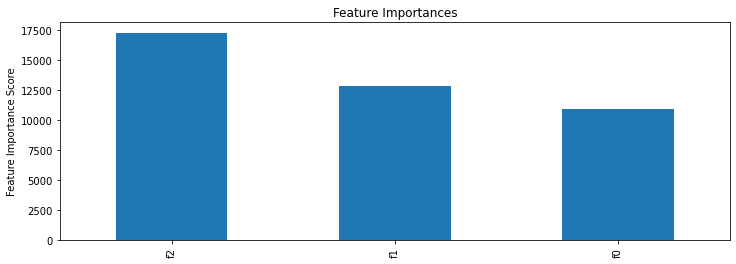

In [14]:
xgb4 = XGBClassifier(learning_rate=0.01,
                     n_estimators=5000,
                     max_depth=best_max_depth,
                     min_child_weight=best_min_child_weight,
                     gamma=best_gamma,
                     subsample=best_subsample,
                     colsample_bytree=best_colsample_bytree,
                     reg_alpha=best_alpha,
                     reg_lamba=best_lambda,
                     objective=objective,
                     num_class=num_classes,
                     nthread=4,
                     scale_pos_weight=1,
                     seed=0)
modelfit(xgb4, X, y)

In [15]:
# Print tuned parameters
print(f"Max depth: {best_max_depth}\n"
      f"Min child weight: {best_min_child_weight}\n"
      f"Gamma: {best_gamma}\n"
      f"Colsample by tree: {best_colsample_bytree}\n"
      f"Subsample: {best_subsample}\n"
      f"Reg alpha: {best_alpha}\n"
      f"Reg lamba: {best_lambda}")

Max depth: 5
Min child weight: 3
Gamma: 0.3
Colsample by tree: 0.67
Subsample: 0.78
Reg alpha: 0
Reg lamba: 0


In [16]:
with open(file_str, "wb") as f:
    pickle.dump(xgb4, f)

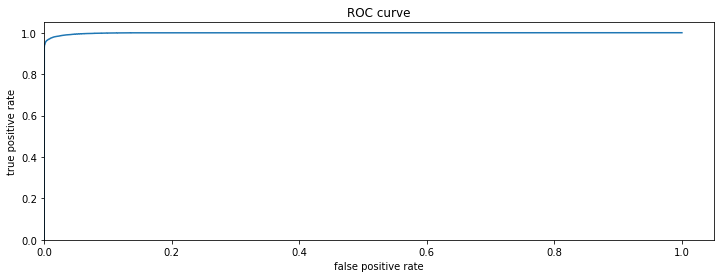

In [17]:
from sklearn.metrics import roc_curve

if CATEGORIZE_FUNC == bin_categorize:
    probs = xgb4.predict_proba(X)
    fpr, tpr, _ = roc_curve(y, probs[:, 1])
    plt.plot(fpr, tpr)
    plt.title('ROC curve')
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    plt.xlim(0,)
    plt.ylim(0,)
    plt.savefig(str(Path(f'./xgboost-models/{feature_str}-{label_str}-xgboost-model-roc-curve.png')))